In [131]:
!which python
!whoami 
!hostname
!pwd

/home/farshed.abdukhakimov/miniconda3/envs/main/bin/python
farshed.abdukhakimov
srv-01
/home/farshed.abdukhakimov/projects/twin-polyak/experiments


In [132]:
%load_ext autoreload
%autoreload 2

import os
import datetime
import time
from collections import defaultdict
import pickle

import numpy as np

import matplotlib.pyplot as plt

import utils
from utils import moving_average
from solve_binary_libsvm import solve_binary_libsvm
from loss_functions import LogisticRegressionLoss, BaseOracle
from np_methods import *

import sklearn
import sklearn.datasets
from sklearn.model_selection import train_test_split

import scipy
import svmlight_loader

from dotenv import load_dotenv
load_dotenv()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

In [133]:
# Synthetic low-rank matrix
np.random.seed(0)
m, n, r = 100, 100, 5  # matrix dimensions and target rank
U_true = np.random.randn(m, r)
V_true = np.random.randn(n, r)
M_full = U_true @ V_true.T

# Observation mask (20% observed entries)
mask = np.random.rand(m, n) < 0.2
M_obs = mask * M_full

In [165]:
def compute_loss(U, V, M_obs, mask, lmd=0.0):
    M_pred = U @ V.T
    diff = (M_obs - M_pred) * mask
    mse = 0.5 * np.sum(diff ** 2)
    reg = 0.5 * lmd * (np.sum(U ** 2) + np.sum(V ** 2))
    return mse + reg

In [195]:
def train_sgd(epochs: int = 100, lr: float = 0.1, reg: float = 0.0):

    U = np.random.randn(m, r)
    V = np.random.randn(n, r)

    losses = []

    observed_indices = np.argwhere(mask)

    epoch_loss = 0.0
    for (i, j) in observed_indices:
        pred = U[i] @ V[j]
        error = pred - M_obs[i, j]
        epoch_loss += error ** 2
    epoch_loss /= len(observed_indices)
    losses.append(epoch_loss)


    for epoch in range(epochs):
        np.random.shuffle(observed_indices)
    
        for (i, j) in observed_indices:
            pred = U[i] @ V[j]
            error = pred - M_obs[i, j]

            grad_Ui = 2 * error * V[j] + 2 * reg * U[i]
            grad_Vj = 2 * error * U[i] + 2 * reg * V[j]

            U[i] -= lr * grad_Ui
            V[j] -= lr * grad_Vj

        total_loss = compute_loss(U, V, M_obs, mask, lmd=reg)
        losses.append(total_loss)
        # print(f"Epoch {epoch+1:02d} | Loss: {epoch_loss:.6f}")

    M_reconstructed = U @ V.T
    relative_error = np.linalg.norm((M_reconstructed - M_full) * mask) / np.linalg.norm(M_full * mask)
    print(f"\nRelative error on observed entries: {relative_error:.6f}")

    return losses, relative_error

In [196]:
def train_sps(epochs: int = 100, eta_max: float = 0.1, reg: float = 0.0):

    U = np.random.randn(m, r)
    V = np.random.randn(n, r)

    losses = []

    observed_indices = np.argwhere(mask)

    eps = 1e-8

    total_loss = compute_loss(U, V, M_obs, mask, reg)
    losses.append(total_loss)

    for epoch in range(epochs):
        np.random.shuffle(observed_indices)
    
        for (i, j) in observed_indices:
            pred = U[i] @ V[j]
            error = pred - M_obs[i, j]

            grad_Ui = 2 * error * V[j] + 2 * reg * U[i]
            grad_Vj = 2 * error * U[i] + 2 * reg * V[j]

            loss_ij = 0.5 * error**2 + 0.5 * reg * (np.sum(U[i]**2) + np.sum(V[j]**2))

            lr_i = loss_ij / ( 0.5 * np.square(np.linalg.norm(grad_Ui)) + eps )
            lr_i = np.minimum(eta_max, lr_i)

            lr_j = loss_ij / ( 0.5 * np.square(np.linalg.norm(grad_Vj)) + eps )
            lr_j = np.minimum(eta_max, lr_j)

            U[i] -= lr_i * grad_Ui
            V[j] -= lr_j * grad_Vj

        total_loss = compute_loss(U, V, M_obs, mask, lmd=reg)
        losses.append(total_loss)
        # print(f"Epoch {epoch+1:02d} | Loss: {epoch_loss:.6f}")

    M_reconstructed = U @ V.T
    relative_error = np.linalg.norm((M_reconstructed - M_full) * mask) / np.linalg.norm(M_full * mask)
    print(f"\nRelative error on observed entries: {relative_error:.6f}")

    return losses, relative_error

In [197]:
def train_stp(epochs: int = 100, reg: float = 0.0):

    Ux = np.random.randn(m, r)
    Vx = np.random.randn(n, r)

    Uy = np.random.randn(m, r)
    Vy = np.random.randn(n, r)

    eps = 1e-8

    observed_indices = np.argwhere(mask)

    losses = []
    total_loss = compute_loss(Ux, Vx, M_obs, mask, lmd=reg)
    losses.append(total_loss)

    for epoch in range(epochs):
        np.random.shuffle(observed_indices)
        epoch_loss = 0.0
        
        for (i, j) in observed_indices:

            
            pred_x = Ux[i] @ Vx[j]
            error_x = pred_x - M_obs[i, j]
            loss_x = 0.5 * error_x**2 + 0.5 * reg * (np.sum(Ux[i]**2) + np.sum(Vx[j]**2))
            grad_Ui_x = 2 * error_x * Vx[j] + 2 * reg * Ux[i]
            grad_Vj_x = 2 * error_x * Ux[i] + 2 * reg * Vx[j] 

            pred_y = Uy[i] @ Vy[j]
            error_y = pred_y - M_obs[i, j]
            loss_y = 0.5 * error_y**2 + 0.5 * reg * (np.sum(Uy[i]**2) + np.sum(Vy[j]**2))
            grad_Ui_y = 2 * error_y * Vy[j] + 2 * reg * Uy[i]
            grad_Vj_y = 2 * error_y * Uy[i] + 2 * reg * Vy[j] 

            lr_Ui_x = np.minimum(( (loss_x - loss_y) / (0.5 * np.linalg.norm(grad_Ui_x)**2 + eps) ), np.inf) 
            lr_Vj_x = np.minimum(( (loss_x - loss_y) / (0.5 * np.linalg.norm(grad_Vj_x)**2 + eps) ), np.inf) 

            lr_Ui_y = np.minimum(( (loss_y - loss_x) / (0.5 * np.linalg.norm(grad_Ui_y)**2 + eps) ), np.inf) 
            lr_Vj_y = np.minimum(( (loss_y - loss_x) / (0.5 * np.linalg.norm(grad_Vj_y)**2 + eps) ), np.inf) 

            if loss_x > loss_y:
                Ux[i] -= lr_Ui_x * grad_Ui_x 
                Vx[j] -= lr_Vj_x * grad_Vj_x 
                loss = loss_y
            else:
                Uy[i] -= lr_Ui_y * grad_Ui_y 
                Vy[j] -= lr_Vj_y * grad_Vj_y
                loss = loss_x

            epoch_loss += loss

        total_loss_x = compute_loss(Ux, Vx, M_obs, mask, lmd=reg)
        total_loss_y = compute_loss(Uy, Vy, M_obs, mask, lmd=reg)

        total_loss = total_loss_x if total_loss_x < total_loss_y else total_loss_y

        losses.append(total_loss)
        # print(f"Epoch {epoch+1:02d} | Loss: {epoch_loss:.6f}")

    if loss_x < loss_y:
        M_reconstructed = Ux @ Vx.T
    else:
        M_reconstructed = Uy @ Vy.T
    relative_error = np.linalg.norm((M_reconstructed - M_full) * mask) / np.linalg.norm(M_full * mask)
    print(f"\nRelative error on observed entries: {relative_error:.6f}")

    return losses, relative_error

In [232]:
reg = 1e-3
epochs = 50


hist_stp, stp_err = train_stp(epochs, reg=reg)

sps_rec_errors = []
sgd_rec_errors = []
lrs_range = range(-20, 20, 5)
for lr_step in lrs_range:
    lr = 2 ** lr_step
    hist, err = train_sps(epochs, lr, reg=reg)
    sps_rec_errors.append(err)

    hist, err = train_sgd(epochs, lr, reg=reg)
    sgd_rec_errors.append(err)


Relative error on observed entries: 0.239030

Relative error on observed entries: 1.433968

Relative error on observed entries: 1.426897

Relative error on observed entries: 1.331974

Relative error on observed entries: 1.299695

Relative error on observed entries: 0.747291

Relative error on observed entries: 0.727178

Relative error on observed entries: 0.003281

Relative error on observed entries: 0.037424

Relative error on observed entries: 0.077553

Relative error on observed entries: nan

Relative error on observed entries: 0.160527

Relative error on observed entries: nan

Relative error on observed entries: 0.360664

Relative error on observed entries: nan

Relative error on observed entries: 0.302122

Relative error on observed entries: nan


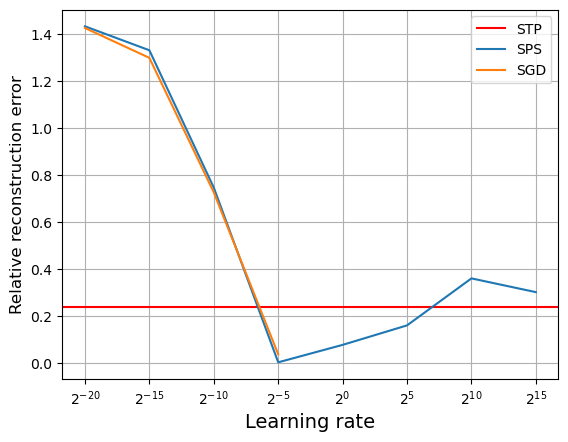

In [233]:

plt.axhline(y=stp_err, label="STP", color='red')

plt.plot(sps_rec_errors, label="SPS")
plt.plot(sgd_rec_errors, label="SGD")


xlabels_true = [x for x in range(0, len(sps_rec_errors))]
xlabels = [r"$2^{{{}}}$".format(x) for x in lrs_range]
plt.xticks(xlabels_true, xlabels)


# xlabels_true = [x for x in range(0, len(stp_min_line), 5)]
# xlabels = [r"$2^{{{}}}$".format(x) for x in range(-20, 20, 5)]
# plt.xticks(xlabels_true, xlabels)

plt.xlabel("Learning rate", fontsize=14)
plt.ylabel("Relative reconstruction error", fontsize=12)

plt.grid()

plt.legend()
plt.show()